In [1]:
# Warning: Check tools1kg.py to set the location for 1000 genome infered trees paths

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import tskit
from tools1kg import path_1000G

plt.style.use('ggplot')

In [3]:
Train = False # Set False if you want to see only the results

if Train:
    import sys
    home_path = '/home/enes/'
    sys.path.append(home_path)

    from bim.utils import InferEta, PConst
    from tools1kg import GWAFS
    
    from tqdm.notebook import trange

In [4]:
ts = tskit.load(path_1000G(22))
pop_meta = pd.DataFrame([json.loads(ts.population(i).metadata) for i in range(26)])
spops = pop_meta.super_population.unique()

In [5]:
if Train:
    GWAFS() # This calculates chromosomewise SFS (AFS) for each population

In [6]:
SFS = np.load("popSFS.npy", allow_pickle=True).item()

In [7]:
t = np.logspace(np.log10(1), np.log10(100000), 100)
t = np.concatenate((np.array([0]), t)) # breakpoints for the time (by generations)

a1 = 0. #sequential l1 penalty 
a2 = 175 #sequential l2 penalty

In [8]:
if Train:
    etaJ = {}
    samplesize = {}
    for i in trange(26):
        sfs = np.array(SFS[i]).sum(0)
        N = len(sfs) + 1
        inferEta = InferEta(N, t, a1 = a1, a2 = a2)
        etaout = inferEta.predict(sfs, maxiter = 1000)

        ti = t
        ai = np.round(etaout.x)

        diff = np.diff(ai).nonzero()[0]

        ti = np.r_[ti[0], ti[diff + 1]]
        ai = np.r_[ai[0], ai[diff + 1]]

        etaJ[i] = {'t':ti.tolist(), 'a':(1/ai).tolist()}
    
    eta_path = 'etas.json'
    with open(eta_path, 'w+') as fp:
        json.dump(etaJ, fp)

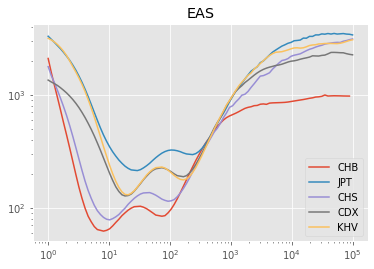

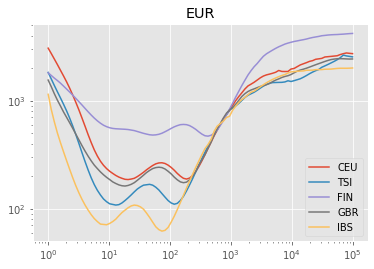

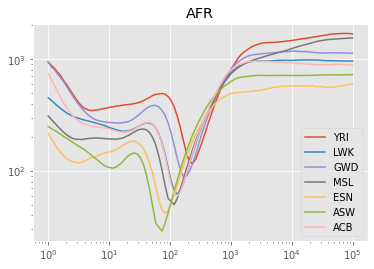

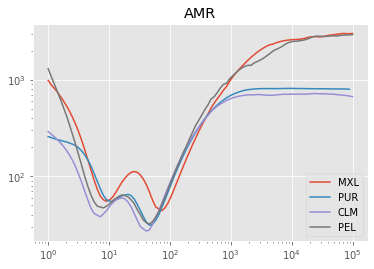

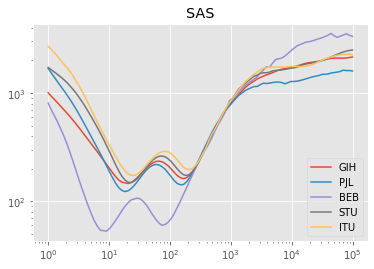

In [9]:
eta_path = 'etas.json'
with open(eta_path, 'r') as fp:
    eta = json.load(fp)

for spop in spops:
    dx = pop_meta[pop_meta.super_population == spop]
    
    for i in dx.index:
        plt.plot(eta[str(i)]['t'][1:], 1/np.array(eta[str(i)]['a'][:-1]), label = dx.loc[i]['name'])

    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.title(spop)
    plt.show()

Text(0, 0.5, 'Effective Population Size')

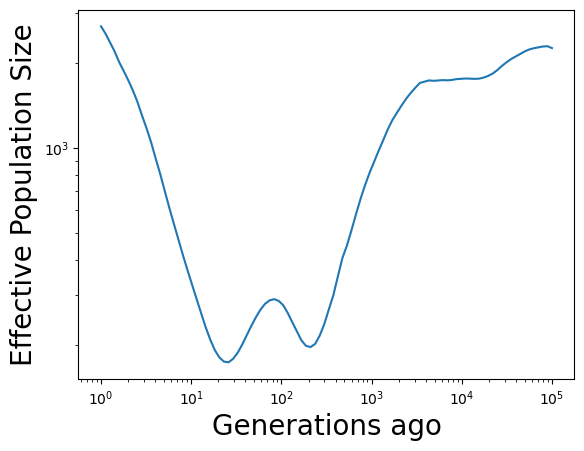

In [17]:
plt.style.use('default')
plt.plot(eta[str(i)]['t'][1:], 1/np.array(eta[str(i)]['a'][:-1]), label = dx.loc[i]['name'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Generations ago', size = 20)
plt.ylabel('Effective Population Size', size = 20)